In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from collections import Counter
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import random
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import re
from google.colab import files
import spacy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
base_path = "/content/drive/MyDrive/Open_Source_Projects/NewTryImageCaptionPrediction/Flicker8k"
checkpoint_path = base_path + "/Checkpoints"
predictions_path = base_path + "/Predictions"

# Caption Directories
captions_file = base_path + "/captions.csv"
token_file = base_path + "/Extracts/tokens.csv"
single_image_path = "/content/drive/MyDrive/Open_Source_Projects/singleImage/"

# Image Directories
image_zip_path = base_path + "/Images.zip"
image_dir='8k'
imaze_unzip_path = "/content/"+ image_dir
image_data_location = imaze_unzip_path +"/Images"

data_folder = "/content/drive/MyDrive/Open_Source_Projects/Image_Captioning"
image_data_location = os.path.join(data_folder, "Flickr8k_Dataset/Flicker8k_Dataset")

# train_test_split
all_image_csv = base_path + "/Extracts/all_images.txt"
train_image_csv =  base_path + "/Extracts/train_images.txt"
test_image_csv = base_path + "/Extracts/test_images.txt"
val_image_csv = base_path + "/Extracts/val_images.txt"

In [ ]:
class Vocabulary:
  itos = {}
  stoi = {}
  spacy_eng = spacy.load('en_core_web_sm')
  def __init__(self, token_file):
    df = pd.read_csv(token_file)
    for idx, row in df.iterrows():
      key = int(row['Index'])
      val = row['Tokens'].strip()
      self.itos[key] = val
      self.stoi[val] = key

  def __len__(self):
    return len(self.itos)

  def tokenize(self, text):
    return [token.text.lower() for token in self.spacy_eng.tokenizer(text)]

  def numericalize(self,text):
    tokenized_text = self.tokenize(text)
    return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text]

In [ ]:
class CaptionUtil:
  caption_dict = {}
  def __init__(self, image_folder, captions_file, tokens_file, train_file, test_file, val_file):
    self.captionsDF = pd.read_csv(captions_file)
    self.captionsDF = self.captionsDF.rename(columns={'comment':'caption', 'image_name':'image'})
    self.captionsDF.drop(columns=['dataset', 'comment_number'], inplace=True)
    self.captionsDF['caption'] = self.captionsDF['caption'].apply(lambda sentence: re.sub('[^a-zA-Z ]+', '', sentence.lower().strip()))
    self.captionsDF['token_count'] = self.captionsDF['caption'].apply(lambda sentence: len(sentence.split()))
    self.optimal_sentence_length = int(np.round(np.average(self.captionsDF['token_count']) + np.std(self.captionsDF['token_count'])*2))
    self.train_test_split(train_file, test_file, val_file)
    self.vocab = Vocabulary(tokens_file)
    for image in self.all_images:
      self.caption_dict[image] = self.captionsDF[self.captionsDF['image'] == image]['caption'].tolist()

  def read2list(self, filename):
    f = open(filename, 'r')
    data = f.read()
    l = data.split('\n')
    if(l[len(l)-1] == ""):
      l.remove("")
    f.close()
    return l

  def train_test_split(self, train_file, test_file, val_file):
    self.train_images = self.read2list(train_file)
    self.test_images = self.read2list(test_file)
    print("printing test images \n")
    print(self.test_images)
    self.val_images = self.read2list(val_file)
    self.all_images = self.train_images + self.test_images + self.val_images

  def get_train_set(self):
    return self.captionsDF[self.captionsDF['image'].isin(self.train_images)]

In [ ]:
class ImageUtil:
  @staticmethod
  def transform(image_path, image_name):
    transform_image = T.Compose([T.Resize((224,224)), T.ToTensor()])
    img = Image.open(os.path.join(image_path,image_name)).convert("RGB")
    return transform_image(img)

  @staticmethod
  def show_image(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1,2,0))
    plt.imshow(inp)
    if title is not None:
      plt.title(title)
    plt.pause(0.001)

In [ ]:
class CustomDataset(Dataset):
  def __init__(self,root_dir, traindf, vocab):
    self.root_dir = root_dir
    self.df = traindf
    self.imgs = self.df["image"].tolist()
    self.captions = self.df["caption"].tolist()
    self.vocab = vocab

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    caption = self.captions[idx]
    img_name = self.imgs[idx]
    img = ImageUtil.transform(self.root_dir, img_name)
    caption_vec = []
    caption_vec += [self.vocab.stoi["<SOS>"]]
    caption_vec += self.vocab.numericalize(caption)
    caption_vec += [self.vocab.stoi["<EOS>"]]
    return img, torch.tensor(caption_vec)

In [ ]:
class CapsCollate:
  def __init__(self,pad_idx,batch_first=False):
    self.pad_idx = pad_idx
    self.batch_first = batch_first

  def __call__(self,batch):
    imgs = [item[0].unsqueeze(0) for item in batch]
    imgs = torch.cat(imgs,dim=0)
    targets = [item[1] for item in batch]
    targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
    return imgs,targets

In [ ]:
class EncoderCNN(nn.Module):
  def __init__(self,embed_size):
    super(EncoderCNN,self).__init__()
    resnet = models.resnet50(pretrained=True)
    for param in resnet.parameters():
      param.requires_grad_(False)

    modules = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*modules)
    self.embed = nn.Linear(resnet.fc.in_features,embed_size)

  def forward(self,images):
    features = self.resnet(images)
    features = features.view(features.size(0),-1)
    features = self.embed(features)
    return features

class DecoderRNN(nn.Module):
  def __init__(self,embed_size,hidden_size,vocab_size,num_layers=1,drop_prob=0.3):
    super(DecoderRNN,self).__init__()
    self.embedding = nn.Embedding(vocab_size,embed_size)
    self.lstm = nn.LSTM(embed_size,hidden_size,num_layers=num_layers,batch_first=True)
    self.fcn = nn.Linear(hidden_size,vocab_size)
    self.drop = nn.Dropout(drop_prob)

  def forward(self,features, captions):
    embeds = self.embedding(captions[:,:-1])
    x = torch.cat((features.unsqueeze(1),embeds),dim=1)
    x,_ = self.lstm(x)
    x = self.fcn(x)
    return x

  def generate_caption(self,inputs,hidden=None,max_len=20,vocab=None):
    batch_size = inputs.size(0)
    captions = []

    for i in range(max_len):
      output,hidden = self.lstm(inputs,hidden)
      output = self.fcn(output)
      output = output.view(batch_size,-1)
      predicted_word_idx = output.argmax(dim=1)
      inputs = self.embedding(predicted_word_idx.unsqueeze(0))

      try:
        token = vocab.itos[predicted_word_idx.item()]
        if token == "<EOS>":
          break
      except:
        token = '<UNK>'
      if not (token == '<SOS>' or token == '<EOS>'):
        captions.append(token)

    return ' '.join(captions)


class EncoderDecoder(nn.Module):
  def __init__(self,embed_size,hidden_size,vocab_size,num_layers=1,drop_prob=0.3):
    super(EncoderDecoder,self).__init__()
    self.encoder = EncoderCNN(embed_size)
    self.decoder = DecoderRNN(embed_size,hidden_size,vocab_size,num_layers,drop_prob)

  def forward(self, images, captions):
    features = self.encoder(images)
    outputs = self.decoder(features, captions)
    return outputs

In [ ]:
Caption_Reader = CaptionUtil(image_data_location, captions_file, token_file, train_image_csv, test_image_csv, val_image_csv)
pad_idx = Caption_Reader.vocab.stoi["<PAD>"]
dataset = CustomDataset(root_dir = image_data_location, traindf = Caption_Reader.get_train_set(), vocab = Caption_Reader.vocab)
data_loader = DataLoader(dataset=dataset, batch_size=50, num_workers=1, shuffle=True, collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True))

printing test images 

['3605061440_1d08c80a57.jpg', '3724718895_bd03f4a4dc.jpg', '2089539651_9e518ec7de.jpg', '3086810882_94036f4475.jpg', '2355093195_87fb7f82cb.jpg', '2058124718_89822bc96e.jpg', '1289142574_2bd6a082dd.jpg', '519228867_2fd25e38d4.jpg', '1574401950_6bedc0d29b.jpg', '1273001772_1585562051.jpg', '461505235_590102a5bf.jpg', '3326024473_4c16e4fbfc.jpg', '2496370758_a3fbc49837.jpg', '190965502_0b9ed331d9.jpg', '173020287_230bfc4ffc.jpg', '3600221224_945df01247.jpg', '2714220101_c31db50b10.jpg', '3068945309_ff0973e859.jpg', '3597924257_d0da3c5fe6.jpg', '3232252882_05db7c2216.jpg', '3386375153_20c56d0aae.jpg', '3151492269_28d8edaa68.jpg', '3415178926_909db9400b.jpg', '3493479159_609ebe1b35.jpg', '2698614194_b4e6e11dff.jpg', '3415809168_af9dabdba5.jpg', '2621415349_ef1a7e73be.jpg', '2599903773_0f724d8f63.jpg', '69710415_5c2bfb1058.jpg', '434792818_56375e203f.jpg', '418667611_b9995000f4.jpg', '2170187328_65c2f11891.jpg', '2774705720_1cb85812dc.jpg', '2726262796_03bd63a155.jpg'

torch.Size([50, 3, 224, 224])
torch.Size([50, 26])
guy in red and white football uniform
tensor([[[0.3529, 0.3490, 0.3412,  ..., 0.4275, 0.4196, 0.4157],
         [0.3569, 0.3451, 0.3333,  ..., 0.4392, 0.4314, 0.4275],
         [0.3490, 0.3373, 0.3255,  ..., 0.4510, 0.4510, 0.4471],
         ...,
         [0.1490, 0.1490, 0.1569,  ..., 0.5373, 0.5608, 0.5765],
         [0.1451, 0.1451, 0.1608,  ..., 0.5255, 0.5490, 0.5725],
         [0.1451, 0.1451, 0.1608,  ..., 0.5137, 0.5490, 0.5608]],

        [[0.3569, 0.3529, 0.3373,  ..., 0.3255, 0.3333, 0.3373],
         [0.3529, 0.3451, 0.3294,  ..., 0.3176, 0.3216, 0.3255],
         [0.3451, 0.3333, 0.3216,  ..., 0.3059, 0.3137, 0.3216],
         ...,
         [0.1529, 0.1529, 0.1608,  ..., 0.3373, 0.3373, 0.3529],
         [0.1451, 0.1529, 0.1725,  ..., 0.3373, 0.3373, 0.3412],
         [0.1451, 0.1529, 0.1725,  ..., 0.3373, 0.3412, 0.3294]],

        [[0.3373, 0.3333, 0.3216,  ..., 0.3176, 0.3294, 0.3373],
         [0.3373, 0.3255, 0.3137, 

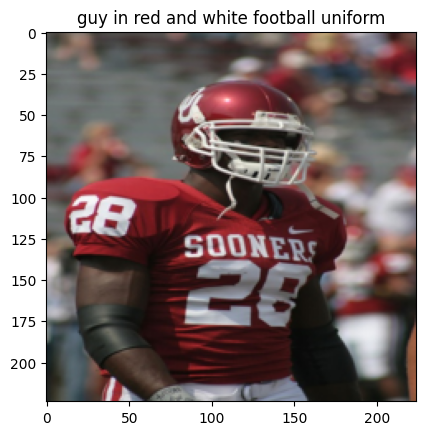

In [ ]:
#generating the iterator from the dataloader
dataiter = iter(data_loader)
batch = next(dataiter)
images, captions = batch
print(images.shape)
print(captions.shape)
for i in range(1):
  img,cap = images[i],captions[i]
  caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
  eos_index = caption_label.index('<EOS>')
  caption_label = caption_label[1:eos_index]
  caption_label = ' '.join(caption_label)
  print(caption_label)
  print(img)
  ImageUtil.show_image(img,caption_label)
  plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# initialize model, loss etc
model = EncoderDecoder(embed_size = 512, hidden_size = 512, vocab_size = len(Caption_Reader.vocab), num_layers=3).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 65.3MB/s]


In [ ]:
def train_epoch(epoch, data_loader, model, optimizer, criterion, vocab_size):
  print_every = 2000
  model.train()
  train_loss = 0.0
  total = 0
  for idx, (image, captions) in enumerate(iter(data_loader)):
    image,captions = image.to(device),captions.to(device)
    optimizer.zero_grad()
    outputs = model(image, captions)
    loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    total += 1
  train_loss = train_loss/total
  print("Epoch: {} loss: {:.5f}".format(epoch, train_loss))
  return model, optimizer, criterion, train_loss

def test_epoch(epoch_num, test_images, model, optimizer,  Caption_Reader, image_data_location):
  image = []
  prediction = []
  model.eval()
  with torch.no_grad():
    for i in range(len(test_images)):
      img = ImageUtil.transform(image_path= image_data_location, image_name=test_images[i]).unsqueeze(0)
      features = model.encoder(img.to(device))
      image.append(test_images[i])
      prediction.append(model.decoder.generate_caption(features.unsqueeze(0),vocab=Caption_Reader.vocab, max_len=Caption_Reader.optimal_sentence_length))
  return image, prediction

def save_ckp(epoch, model, optimizer):
  checkpoint = {'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(), 'epoch': epoch}
  filename = 'Checpoint_'+str(epoch)+'.pt'
  checkpoint_name = os.path.join(checkpoint_path, filename)
  torch.save(checkpoint, checkpoint_name)

#Function to Load Checkpoint
def load_ckp(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

def train_test(epoch, test_ds, model, optimizer, criterion, Caption_Reader, image_data_location):
  model, optimizer, criterion, loss = train_epoch(epoch, data_loader, model, optimizer, criterion,len(Caption_Reader.vocab))
  imgName, prediction = test_epoch(epoch, Caption_Reader.val_images, model, optimizer, criterion, Caption_Reader, image_data_location)
  train_loss = [loss for i in imgName]
  epoch = [epoch for i in imgName]
  results = pd.DataFrame({'Epoch':epoch, 'ImageName': imgName, 'Predicted': prediction, 'TrainLoss':train_loss})
  return results, model, optimizer, criterion


In [ ]:
#load_ckp(checkpoint_path + '/Checpoint_50.pt', model, optimizer)

#model.decoder.fcn = nn.Linear(512,15000)
#model.children
#8k - 8192 (1 - The, 10- like)
#30 - 15000 (1 - like 19 - the)


In [ ]:
result = []
for i in range(25):
  resultDF, model, optimizer, criterion = train_test(i+1, data_loader, model, optimizer, criterion, Caption_Reader, image_data_location)
  result.append(resultDF)
  if ((i+1)%5 == 0):
    save_ckp(i+1, model, optimizer)
    Results = pd.concat(result, ignore_index=True)
    Results.to_csv(predictions_path+'/TrainPredictions_'+str(i+1)+'.csv')


Epoch: 1 loss: 5.05205
Epoch: 2 loss: 4.35736
Epoch: 3 loss: 3.94405
Epoch: 4 loss: 3.69110
Epoch: 5 loss: 3.52005
Epoch: 6 loss: 3.38794
Epoch: 7 loss: 3.27880
Epoch: 8 loss: 3.17849
Epoch: 9 loss: 3.08018
Epoch: 10 loss: 2.98687
Epoch: 11 loss: 2.90091
Epoch: 12 loss: 2.82114
Epoch: 13 loss: 2.74754
Epoch: 14 loss: 2.67726
Epoch: 15 loss: 2.60897
Epoch: 16 loss: 2.54564
Epoch: 17 loss: 2.48667
Epoch: 18 loss: 2.42502
Epoch: 19 loss: 2.36910
Epoch: 20 loss: 2.31345
Epoch: 21 loss: 2.26096
Epoch: 22 loss: 2.20914
Epoch: 23 loss: 2.15932
Epoch: 24 loss: 2.11027
Epoch: 25 loss: 2.06192


In [ ]:
test_image = ['TestImage4.jpg']
load_ckp(checkpoint_path + '/Checpoint_25.pt', model, optimizer)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
imgName, prediction = test_epoch(1, test_image, model, optimizer,  Caption_Reader, single_image_path)
test_results = pd.DataFrame({'ImageName': imgName, 'Predicted': prediction})
print(test_results)
#test_results.to_csv(predictions_path + '/TestPerdictions.csv')

<ipython-input-13-f1beb8cdecf9>:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


        ImageName                                          Predicted
0  TestImage4.jpg  closely scored hortons closely choppy mission ...
